# Gravity Spy Code

In [20]:
# -*- coding: utf-8 -*-
# Copyright (C) Scott Coughlin (2017-)
#
# This file is part of gravityspy.
#
# gravityspy is free software: you can redistribute it and/or modify
# it under the terms of the GNU General Public License as published by
# the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# gravityspy is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# You should have received a copy of the GNU General Public License
# along with gravityspy.  If not, see <http://www.gnu.org/licenses/>.

"""Plotting tool for gravityspy
"""
%matplotlib inline
from matplotlib import use
#use('agg')
from matplotlib import pyplot
from matplotlib.ticker import ScalarFormatter

from mpl_toolkits.axes_grid1 import make_axes_locatable

from gwpy.plot import Plot

import numpy


def plot_qtransform(specsgrams, plot_normalized_energy_range, plot_time_ranges,
                    detector_name, start_time, **kwargs):
    """Fetch raw data around a glitch

    Parameters:

        specsgrams (list):
            A list of `gwpy.spectrogram.Spectrogram` objects

        plot_normalized_energy_range (array):
            The min and max of the colorbar for the plots

        plot_time_ranges (array):
            The duration assosciated with each plot to be made

        detector_name (str):
            What detetor where these spectrograms from

        start_time (float):
            What was the start time of the data used for these spectrograms
            this effects what the plot title is (ER10 O1 O2 etc)

    Returns:

        ind_fig_all
            A list of individual spectrogram plots
        super_fig
            A single `plot` object contianing all spectrograms
    """
    frange = kwargs.pop('frange', [10, 2048]) #2048

    # Set some plotting params
    myfontsize = 15
    mylabelfontsize = 20
    my_color = 'k'
    if detector_name == 'H1':
        title = "Hanford"
    elif detector_name == 'L1':
        title = "Livingston"
    elif detector_name == 'V1':
        title = "VIRGO"
    elif detector_name == 'G1':
        title = "GEO"
    elif detector_name == 'K1':
        title = "KAGRA"
    else:
        raise ValueError('You have supplied a detector '
                         'that is unknown at this time.')

    if start_time < 1126400000:
        title = title + ' - pre O1'
    elif 1126400000 < start_time < 1137250000:
        title = title + ' - O1'
    elif 1137250000 < start_time < 1161907217:
        title = title + ' - post O1 pre ER10'
    elif 1161907217 < start_time < 1164499217:
        title = title + ' - ER10'
    elif 1164499217 < start_time < 1219276818:
        title = title + ' - O2a'
    elif 1219276818 < start_time < 1228838418:
        title = title + ' - post O2 pre ER13'
    elif 1228838418 < start_time < 1229176818:
        title = title + ' - ER13'
    elif 1229176818 < start_time < 1235750418:
        title = title + ' - post ER13 pre O3'
    elif 1235750418 <start_time < 1238112018:
        title = title + ' - ER14'
    elif 1238112018 <start_time:
        title = title + ' - O3'
    else:
        raise ValueError('Time outside science or engineering run '
                         'or more likely code not updated to reflect '
                         'new science run.')

    ind_fig_all = []

    for i, spec in enumerate(specsgrams):

        ind_fig = spec.plot(figsize=[8, 6])

        ax = ind_fig.gca()
        ax.set_position([0.125, 0.1, 0.775, 0.8])
        ax.set_yscale('log', base=2)
        ax.set_xscale('linear')
        ax.grid(False)

        dur = float(plot_time_ranges[i])

        xticks = numpy.linspace(spec.xindex.min().value,
                                spec.xindex.max().value, 5)

        xticklabels = []
        for itick in numpy.linspace(-dur/2, dur/2, 5):
            xticklabels.append(str(itick))

        ax.set_xticks(xticks)
        ax.set_xticklabels(xticklabels)

        ax.set_xlabel('Time (s)', labelpad=0.1, fontsize=mylabelfontsize,
                      color=my_color)
        ax.set_ylabel('Frequency (Hz)', fontsize=mylabelfontsize,
                      color=my_color)
        ax.set_title(title, fontsize=mylabelfontsize, color=my_color)
        ax.title.set_position([.5, 1.05])
        ax.set_ylim(frange)
        ax.yaxis.set_major_formatter(ScalarFormatter())
        ax.ticklabel_format(axis='y', style='plain')

        plt.tick_params(axis='x', which='major', labelsize=myfontsize)
        plt.tick_params(axis='y', which='major', labelsize=12)

        divider = make_axes_locatable(ax)
        cax = divider.append_axes("right", size="5%", pad="3%")

        cbar = ind_fig.colorbar(cax=cax, cmap='viridis',
                                label='Normalized energy',
                                clim=plot_normalized_energy_range)

        cbar.ax.tick_params(labelsize=12)
        cbar.ax.yaxis.label.set_size(myfontsize)

        ind_fig_all.append(ind_fig)

    # Create one image containing all spectogram grams
    super_fig, axes = plt.subplots(nrows=1, ncols=len(specsgrams),
                                      sharey=True,
                                      subplot_kw={'xscale': 'auto-gps'},
                                      figsize=(27, 6), FigureClass=Plot)
    count = 0

    for iax, spec in zip(axes, specsgrams):
        iax.imshow(spec)

        iax.set_yscale('log', base=2)
        iax.set_xscale('linear')

        xticks = numpy.linspace(spec.xindex.min().value,
                                spec.xindex.max().value, 5)
        dur = float(plot_time_ranges[count])

        xticklabels = []
        for itick in numpy.linspace(-dur/2, dur/2, 5):
            xticklabels.append(str(itick))

        iax.set_xticks(xticks)
        iax.set_xticklabels(xticklabels)

        iax.set_xlabel('Time (s)', labelpad=0.1, fontsize=mylabelfontsize,
                       color=my_color)
        iax.set_ylim(frange)
        iax.yaxis.set_major_formatter(ScalarFormatter())
        iax.ticklabel_format(axis='y', style='plain')
        iax.colorbar(clim=plot_normalized_energy_range)
        count = count + 1

    super_fig.suptitle(title, fontsize=mylabelfontsize, color=my_color, x=0.51)

    return ind_fig_all, super_fig

([<Plot size 800x600 with 2 Axes>, <Plot size 800x600 with 2 Axes>],
 <Plot size 2700x600 with 4 Axes>)

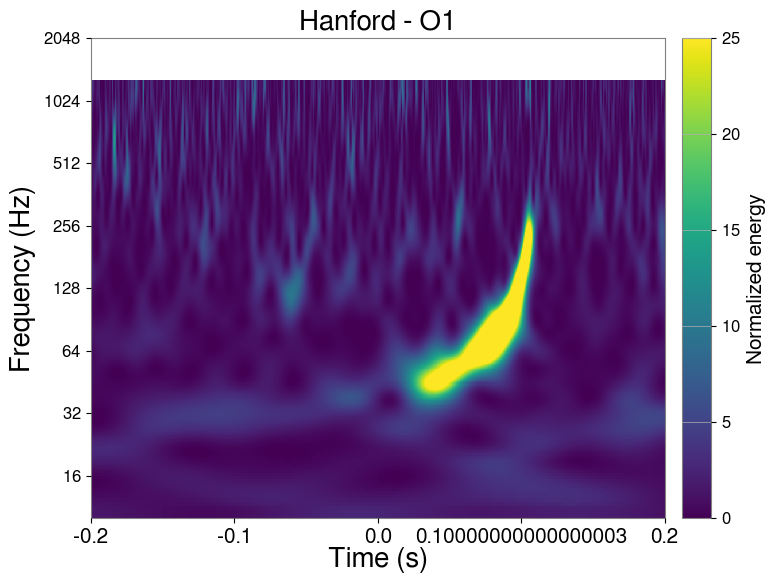

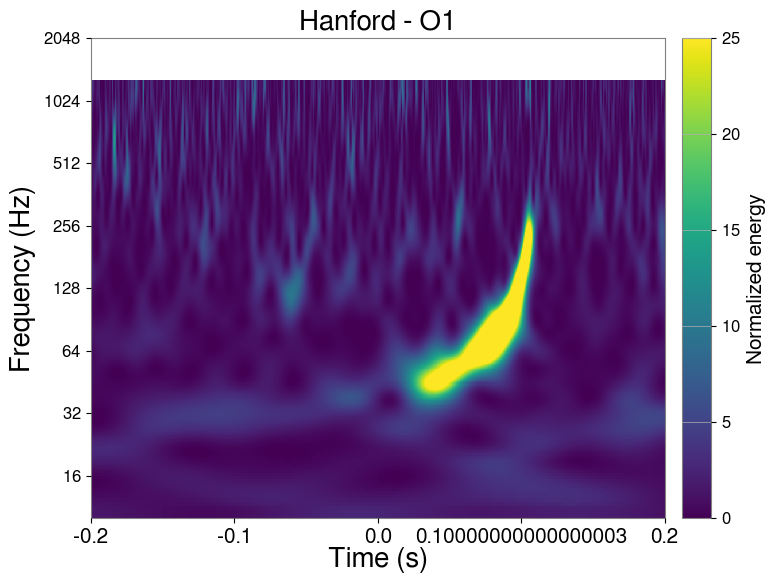

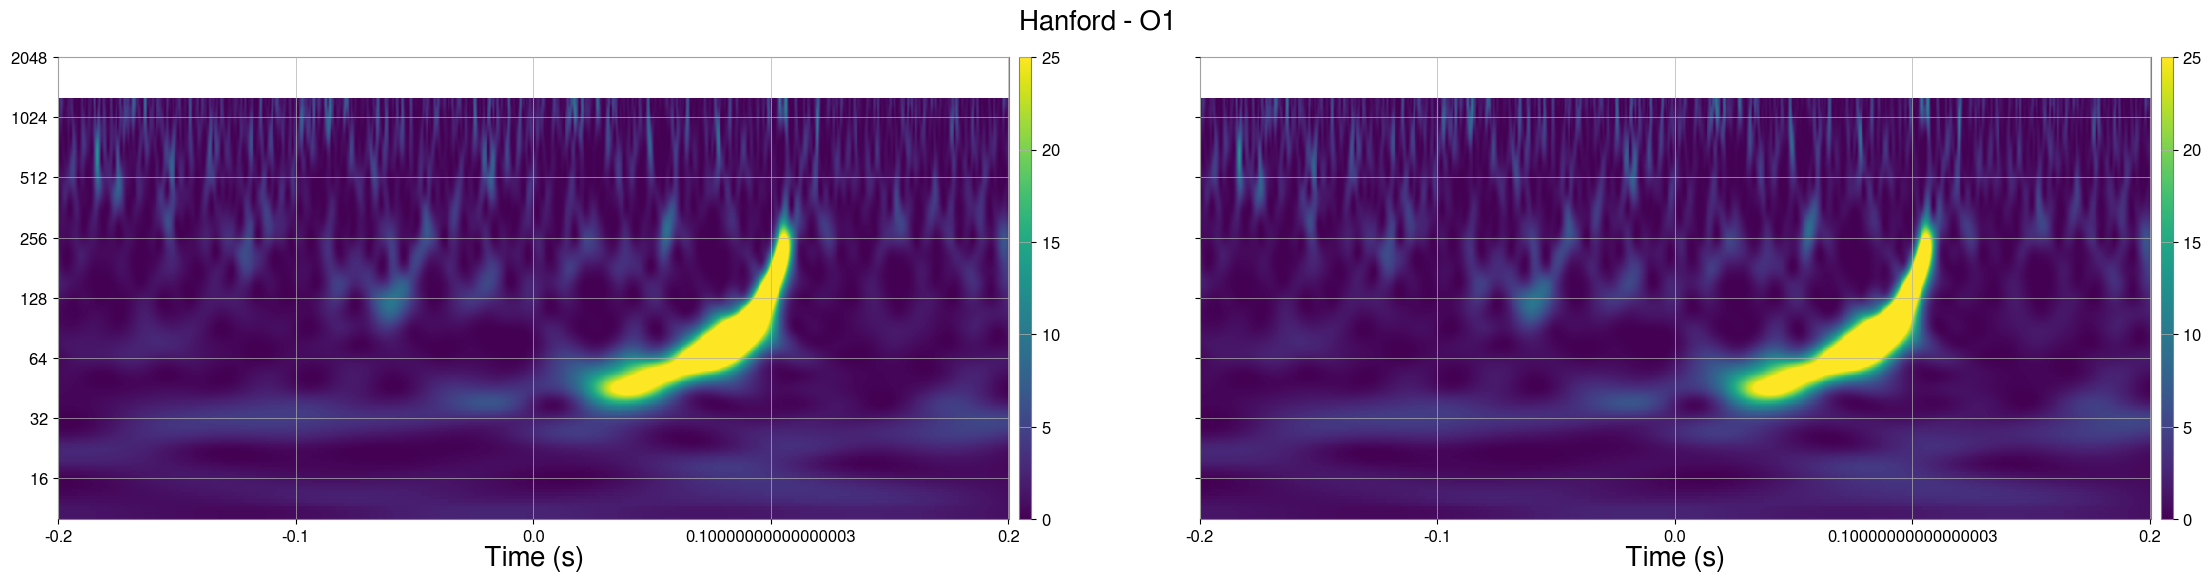

In [21]:
specsgrams = [qspecgram,qspecgram]
plot_normalized_energy_range = (0,25)
plot_time_ranges = [0.4, 0.4]
detector_name = 'H1'
start_time = int(start_time)

plot_qtransform(specsgrams, plot_normalized_energy_range, plot_time_ranges,
                    detector_name, start_time)

In [47]:
qspecgram.xindex.min().value

1131191380.7

In [50]:
str(numpy.linspace(-dur/2, dur/2, 5))

'[-0.2 -0.1  0.   0.1  0.2]'